In [236]:
import anndata as ad
import pandas as pd
import shapely
import shapely.plotting as splot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [201]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
adata = ad.read_h5ad("../data/merfish_638850_AIT17.custom_CCF_annotated_TH_ZI_only_2023-05-04_00-00-00/atlas_brain_638850_AIT17_custom_CCF_annotated_TH_ZI_only.h5ad")
adata

AnnData object with n_obs × n_vars = 191578 × 550
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'cluster_id', 'cluster_label', 'supertype_id_label', 'Level2_id_label', 'Level1_id_label', 'class_id_label', 'cluster_id.AIT16', 'nt_type_label', 'luster_id', 'subclass_id_label', 'He.label', 'He.cor', 'class_label', 'division_label', 'division_id_label', 'subclass_label', 'supertype_label', 'nt_type_combo_label', 'CCF_landmark', 'CCF_bin_x', 'CCF_bin_y', 'CCF_bin_z', 'structures_id', 'CCF_acronym', 'CCF_analysis', 'CCF_broad', 'napari_x', 'napari_y', 'is_in_TH_or_ZI'
    u

In [3]:
adata.obs['cirro_x'] = adata.obsm['spatial_cirro'][:,0]
adata.obs['cirro_y'] = adata.obsm['spatial_cirro'][:,1]

# define and view CCF polygons

In [198]:
def plot_shape(poly, **kwargs):
    if type(poly) is shapely.GeometryCollection:
        for subpoly in poly.geoms:
            patch = splot.plot_polygon(subpoly, add_points=False, **kwargs)
    else:
        patch = splot.plot_polygon(poly, add_points=False, **kwargs)
    return patch

In [161]:
from collections import defaultdict
from shapely.ops import unary_union
from sklearn.cluster import OPTICS, DBSCAN, k_means

def poly_from_points(X):
    if X.shape[0] < 10:
        return None
    poly = shapely.concave_hull(shapely.multipoints(X), allow_holes=True, ratio=0.3)
    if type(poly) is shapely.Polygon:
        return poly
    else:
        return None

In [162]:
# data = adata.obs.query("section=='1199651024'")

# ccf_polygons = defaultdict(dict)  
# for (name, section), df in data.groupby(['CCF_acronym', 'section']):
#     X = df[['cirro_x','cirro_y']].values
#     if X.shape[0] > 100:
#         clusters = OPTICS(min_cluster_size=50, min_samples=10, n_jobs=2).fit_predict(X)
#         results = [poly_from_points(X[clusters==i, :]) for i in set(clusters) if not i==-1]
#         ccf_polygons[name][section] = unary_union(results)
        

In [182]:
def get_ccf_polygons(data):
    ccf_polygons = defaultdict(dict)  
    for (name, section), df in data.groupby(['CCF_acronym', 'section']):
        X = df[['cirro_x','cirro_y']].values
        if X.shape[0] > 100:
            centroids, _, _ = k_means(X, 2, n_init=5)
            midpoint = np.mean(centroids, 0)[0]
            # midpoint = df['cirro_x'].mean()
            if np.min(np.abs(X[:,0] - midpoint)) > 100:
                left = X[X[:,0] < midpoint]
                right = X[X[:,0] > midpoint]
                ccf_polygons[name][section] = unary_union([poly_from_points(left), poly_from_points(right)])
            else:
                poly = poly_from_points(X)
                if poly is not None:
                    ccf_polygons[name][section] = poly
    return ccf_polygons

In [183]:
ccf_polygons = get_ccf_polygons(adata.obs)

In [ ]:
import colorcet as cc

def plot_ccf_overlay(obs, ccf_polygons, sections, point_hue='CCF_acronym', legend=True, min_group_count=10, highlight=[]):
    ccf_names = ccf_polygons.keys()
    shape_palette = dict(zip(ccf_names, sns.color_palette(cc.glasbey, n_colors=len(ccf_names))))
    group_names = obs[point_hue].value_counts().loc[lambda x: x>min_group_count].index
    point_palette = dict(zip(group_names, sns.color_palette(cc.glasbey, n_colors=len(group_names))))

    for section in sections:
        plt.figure(figsize=(10,4))
        plt.title(section)
        patches = []
        for i, name in enumerate(ccf_polygons.keys()):
            if section in ccf_polygons[name]:
                patches.append(plot_shape(ccf_polygons[name][section], color=shape+palette[name], 
                                          alpha=0.4 if name in highlight else 0.1, 
                                          label=name if legend=='CCF' else None))
        
        secdata = obs.loc[lambda df: (df['section']==section) & df['CCF_acronym'].isin(ccf_names)]
        if min_group_count>0:
            groups = secdata[point_hue].value_counts().loc[lambda x: x>min_group_count].index
            secdata = secdata.loc[lambda df: df[point_hue].isin(groups)]
        secdata[point_hue].cat.remove_unused_categories(inplace=True)
        sns.scatterplot(secdata, x='cirro_x', y='cirro_y', hue=point_hue, s=2, palette=point_palette, legend=legend is True)
        if legend=='CCF':
            plt.legend(title='CCF regions', handles=patches, ncols=2, loc='upper left', bbox_to_anchor=(1,1))

## view all slices with polygons and labeled points

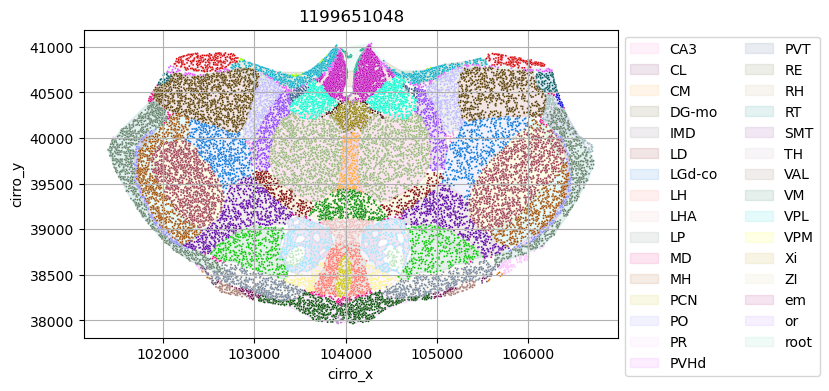

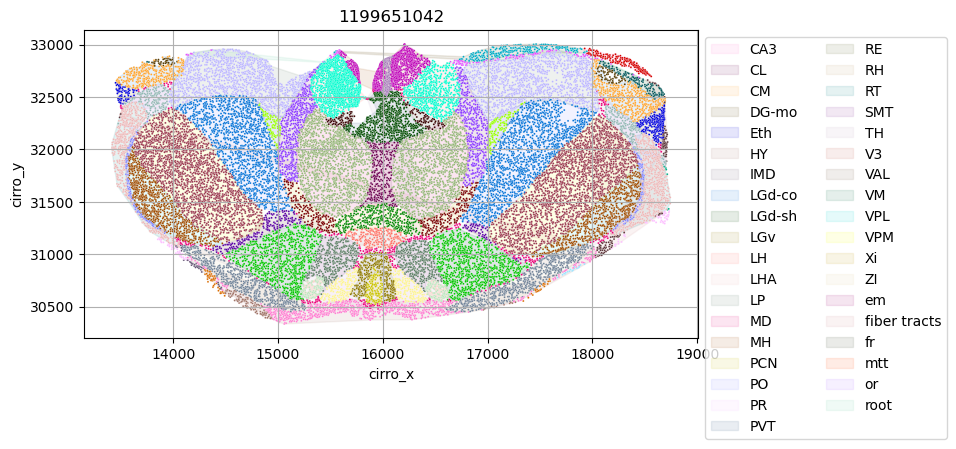

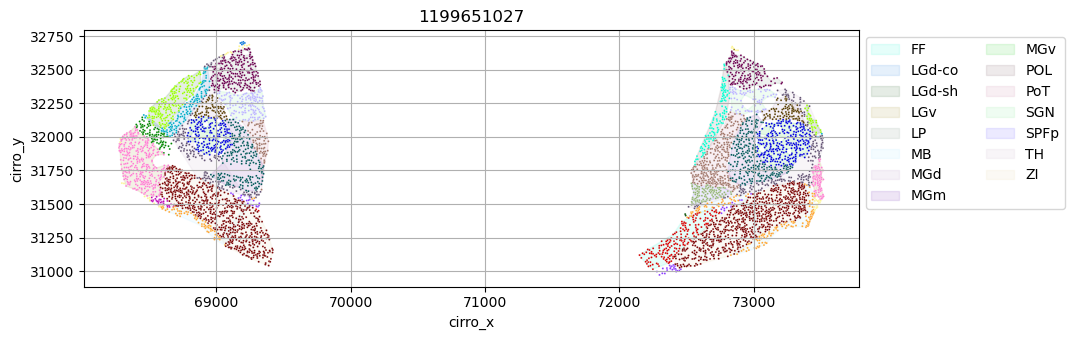

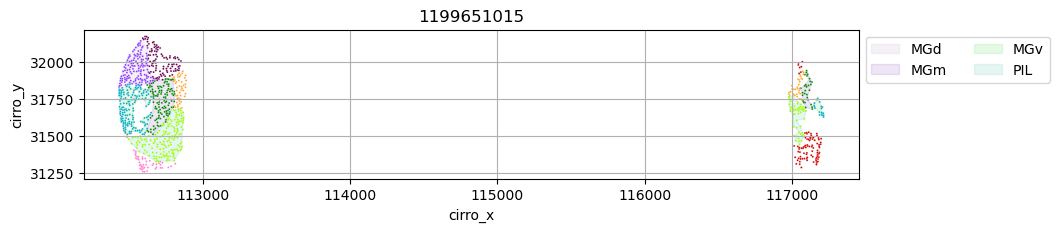

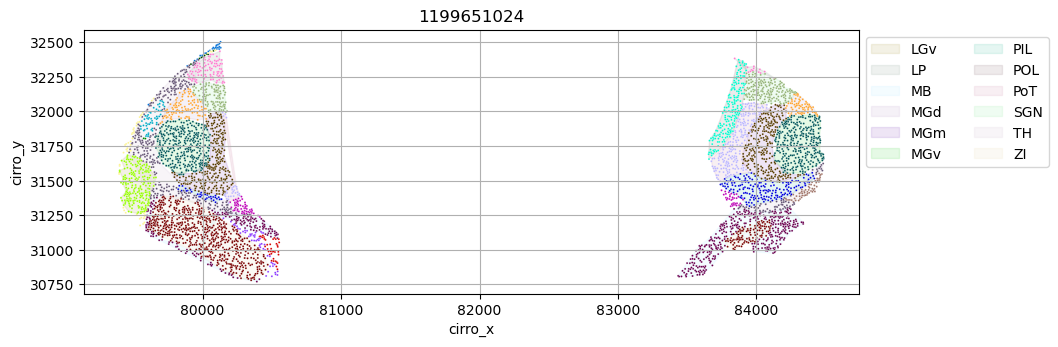

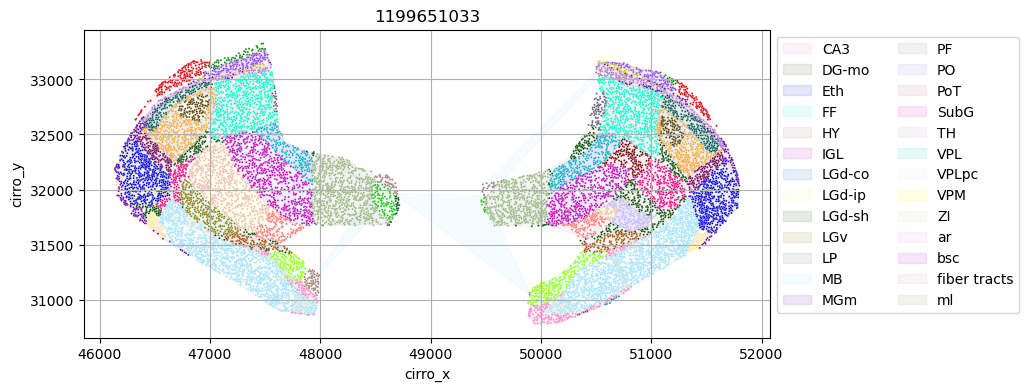

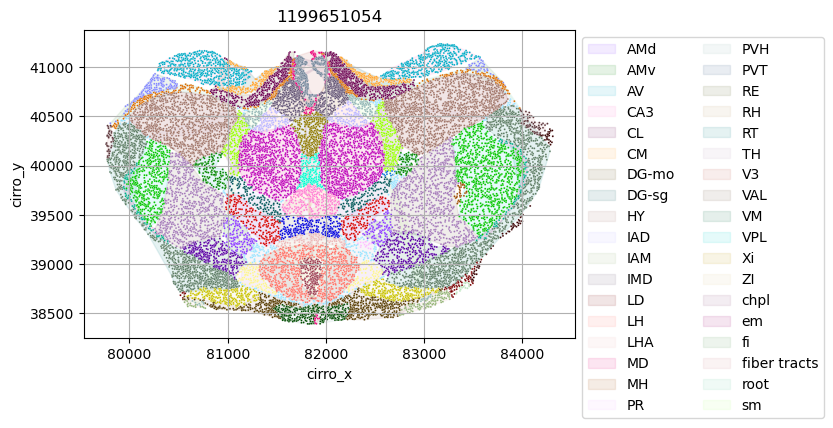

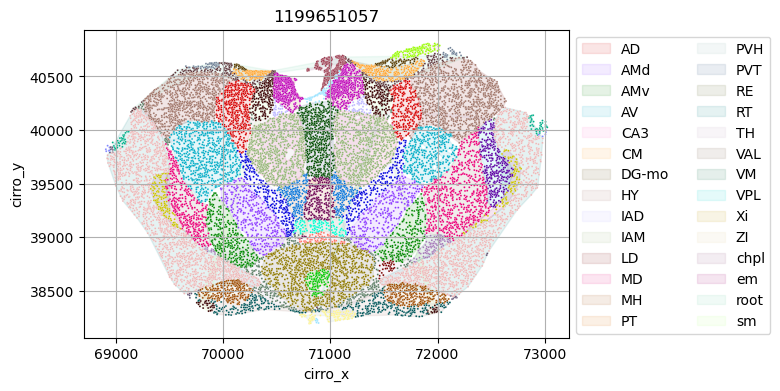

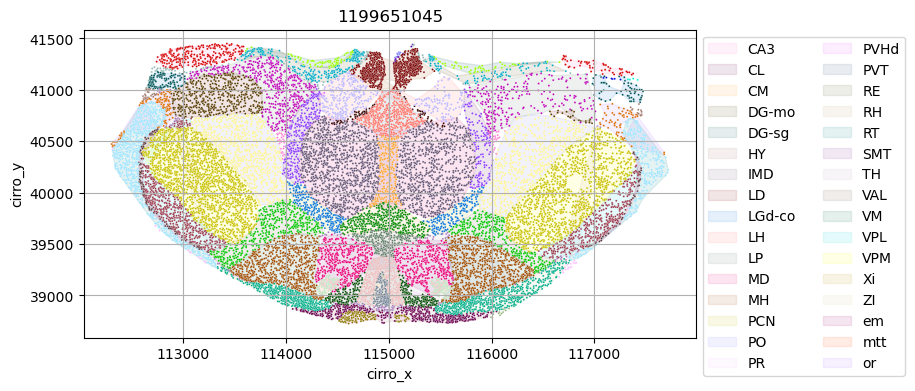

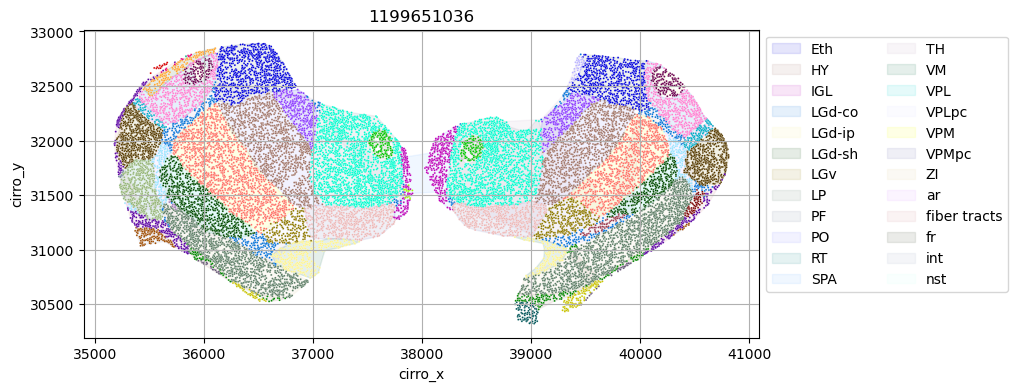

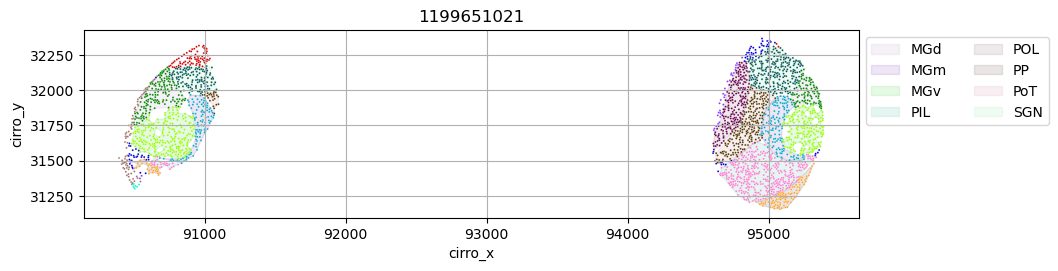

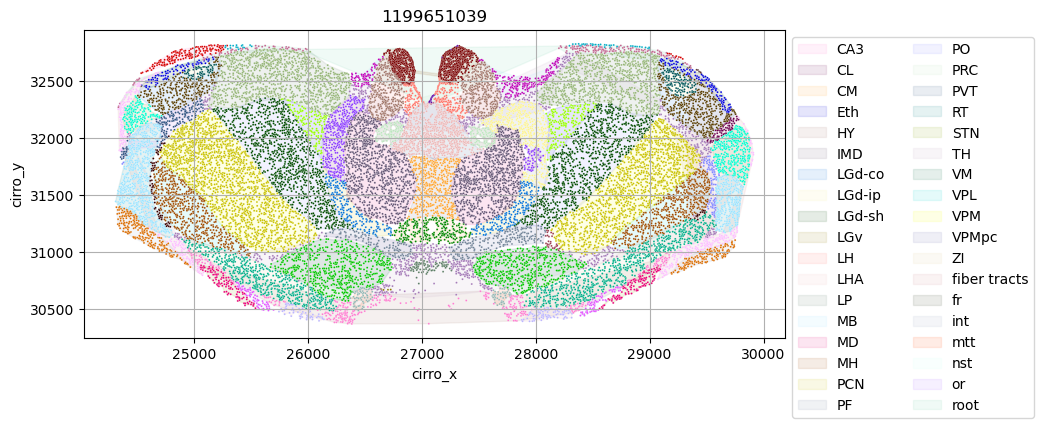

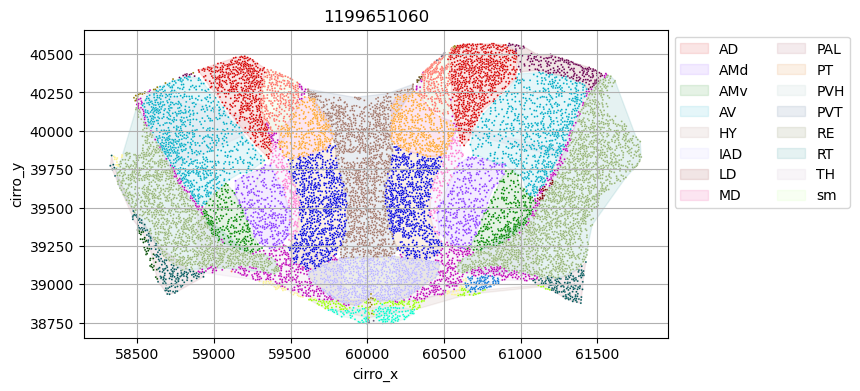

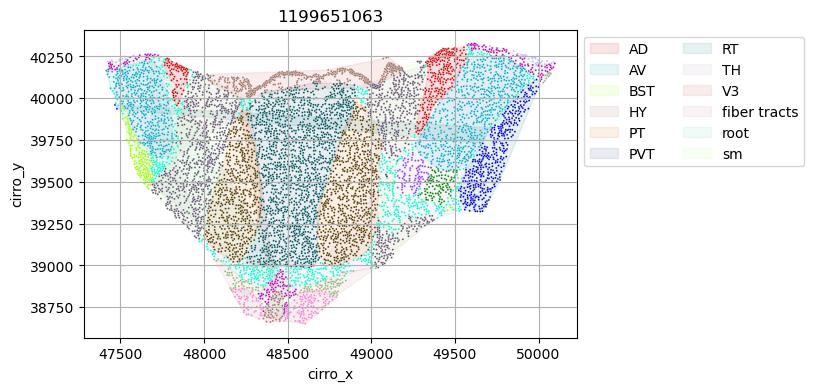

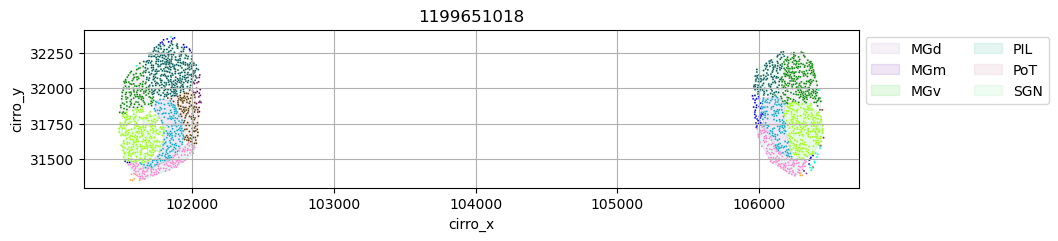

In [206]:
sections = set.union(*(set(x.keys()) for x in ccf_polygons.values()))

plot_ccf_overlay(adata.obs, ccf_polygons, sections, point_hue='CCF_acronym', legend=False)

## view with subclass labels

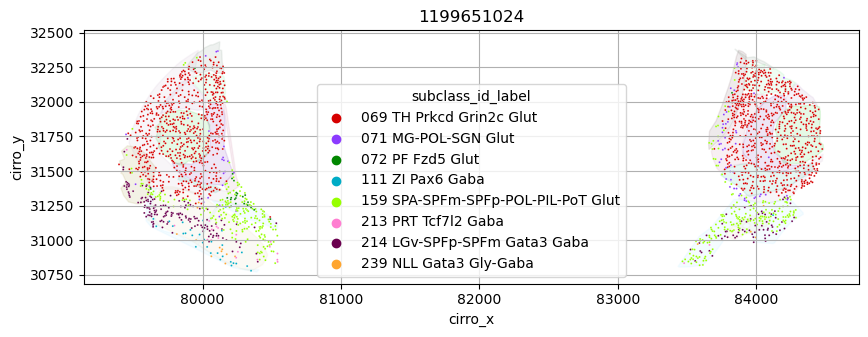

In [220]:
sections = ['1199651024']
obs = adata.obs.loc[lambda df: df['division_id_label']=='3 PAL-sAMY-TH-HY-MB-HB neuronal']
plot_ccf_overlay(obs, ccf_polygons, sections, point_hue='subclass_id_label', legend=True)

# Investigate prong 1 cluster-nucleus groups

In [237]:
nuclei_df = pd.read_csv("../resources/Prong 1 Vitessce links by nucleus.csv", index_col=0)

ParserError: Error tokenizing data. C error: Expected 6 fields in line 3, saw 8


In [238]:
def plot_nucleus_cluster_comparison_slices(name, adata, nuclei_df, ccf_polygons, subregions=None, legend=True):
    clusters = nuclei_df.loc[name, "annotated clusters"].split(', ')
    obs = adata.obs.loc[lambda df: df['cluster_label'].str[:4].isin(clusters)]
    sections = obs['section'].value_counts().loc[lambda x: x>10].index.sort_values()
    nuclei = subregions or [name]
    plot_ccf_overlay(obs, ccf_polygons, sections, point_hue='cluster_label', legend=legend, highlight=nuclei)

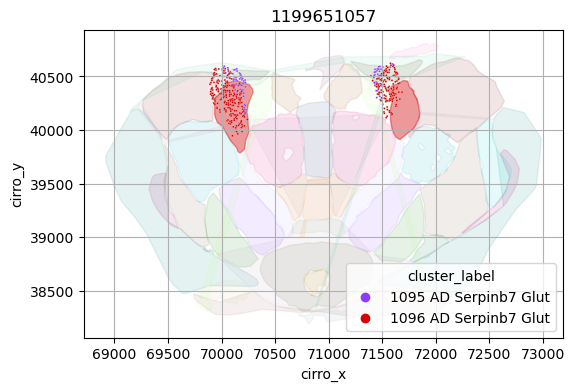

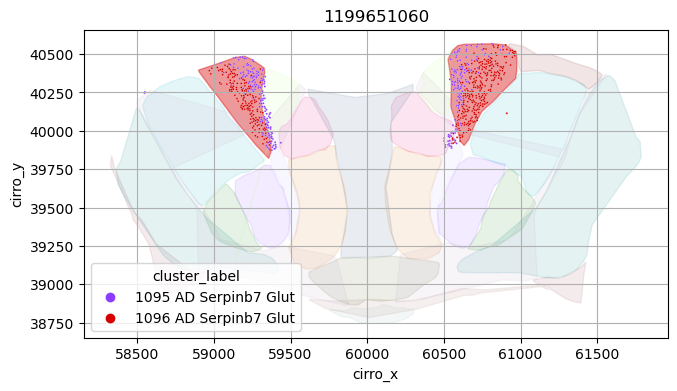

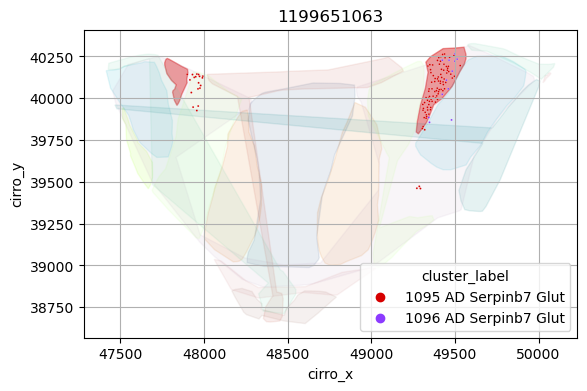

In [239]:
plot_nucleus_cluster_comparison_slices('AD', adata, nuclei_df, ccf_polygons)

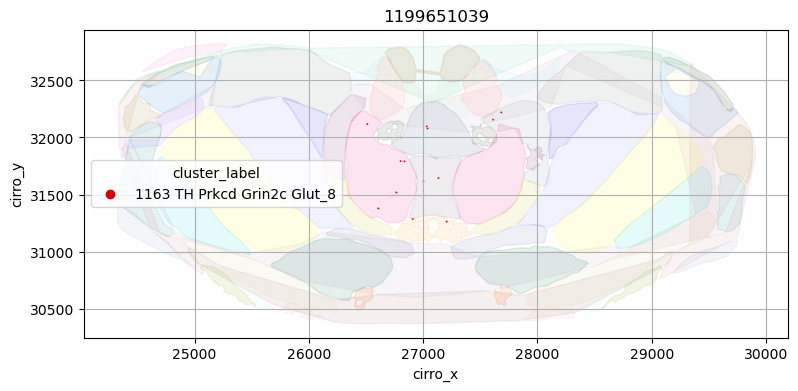

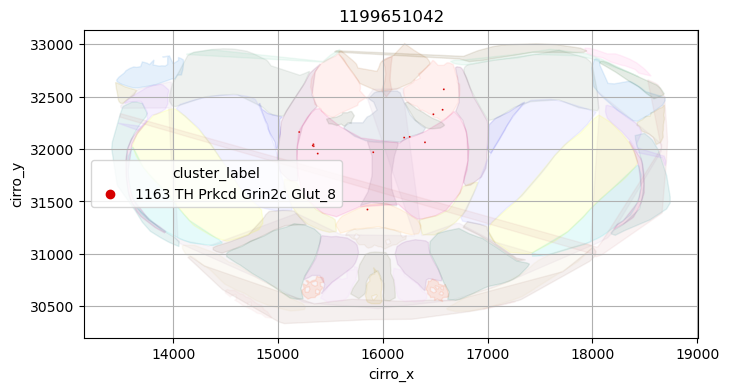

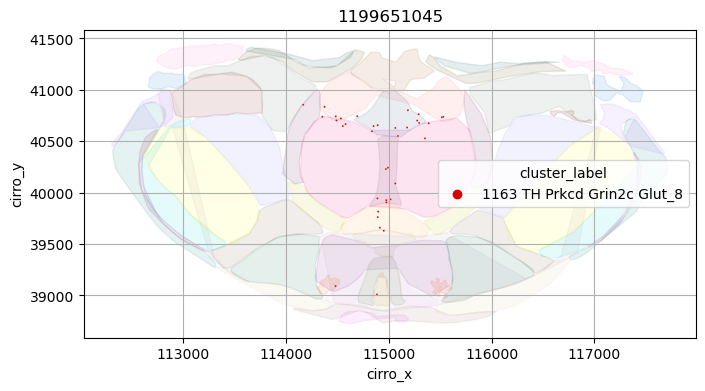

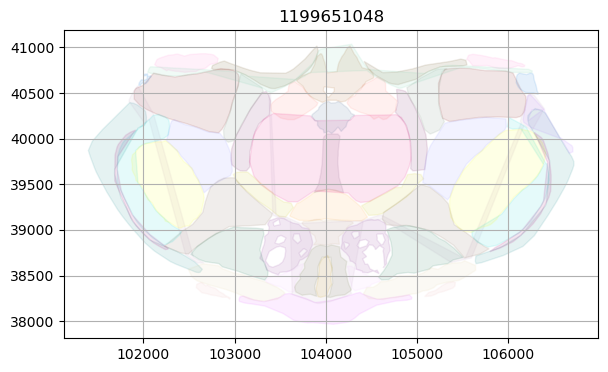

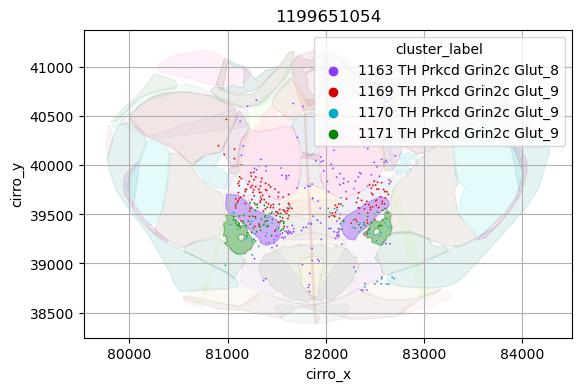

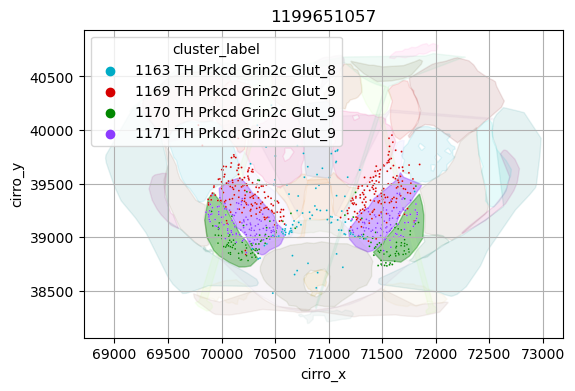

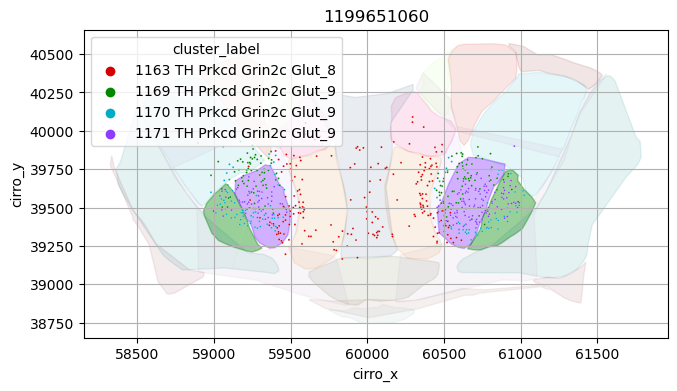

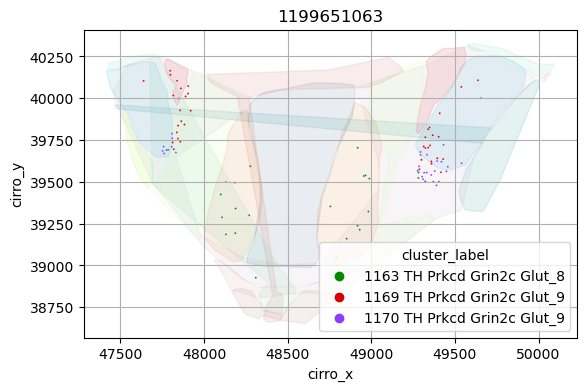

In [240]:
plot_nucleus_cluster_comparison_slices('AM', adata, nuclei_df, ccf_polygons, subregions=['AMd','AMv'])

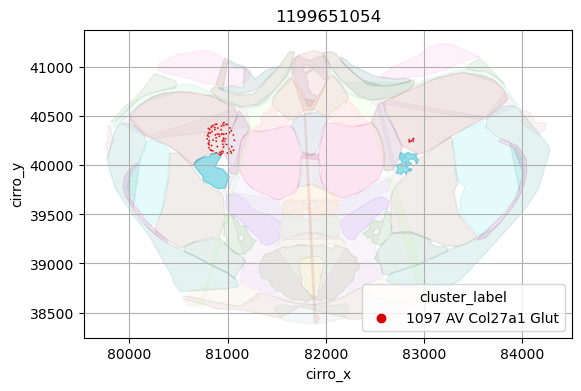

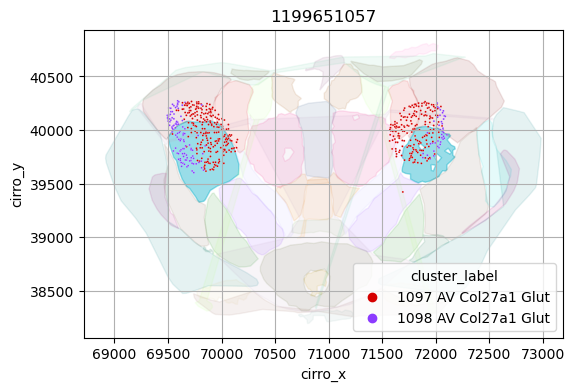

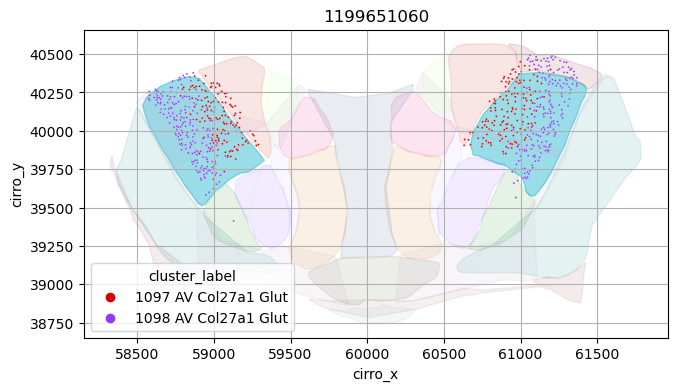

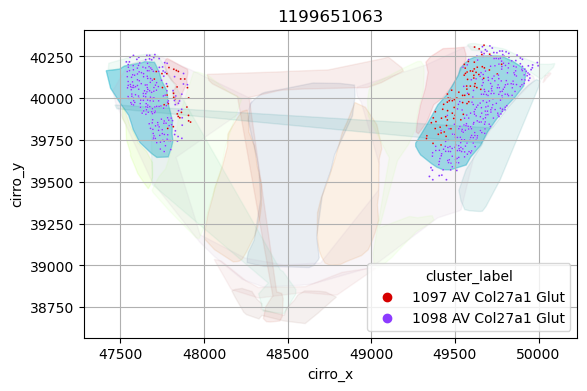

In [241]:
plot_nucleus_cluster_comparison_slices('AV', adata, nuclei_df, ccf_polygons)

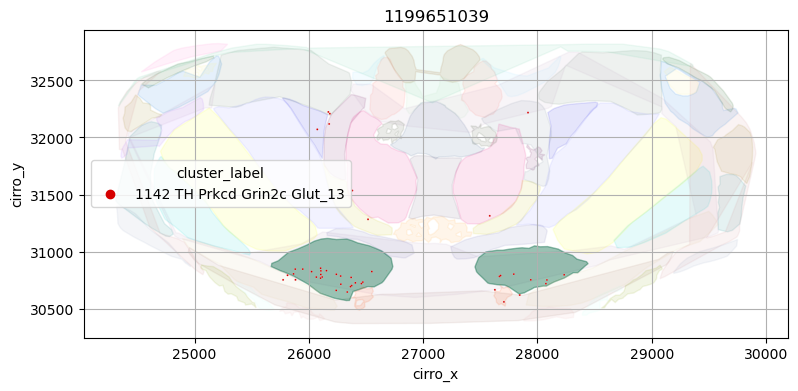

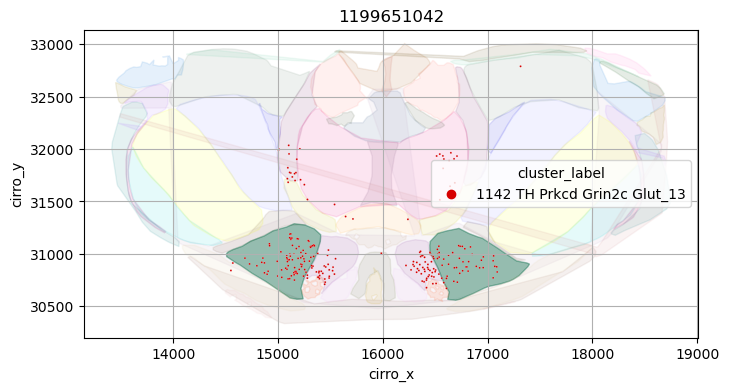

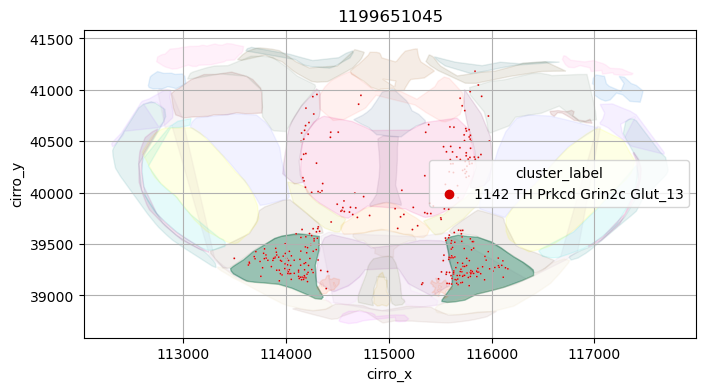

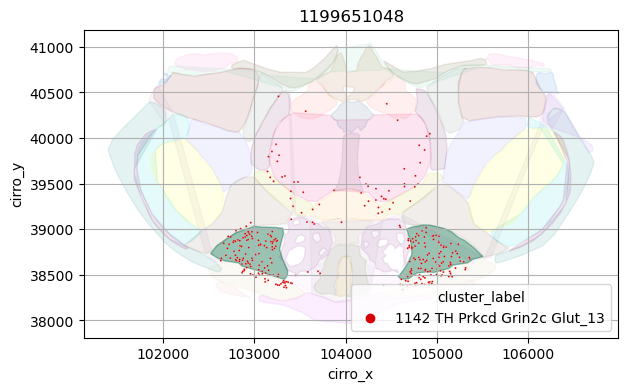

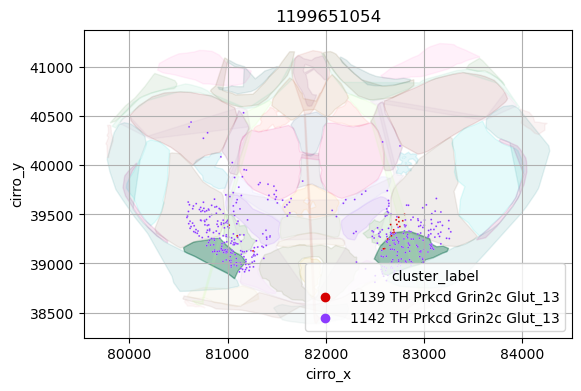

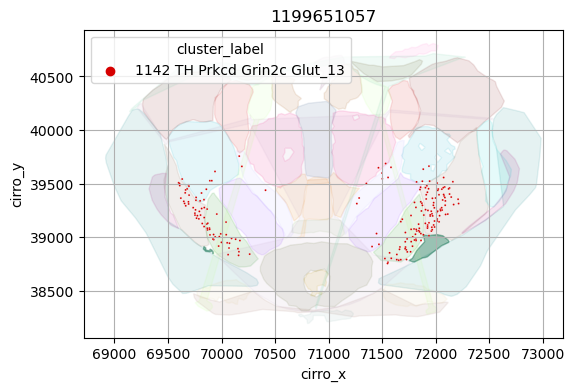

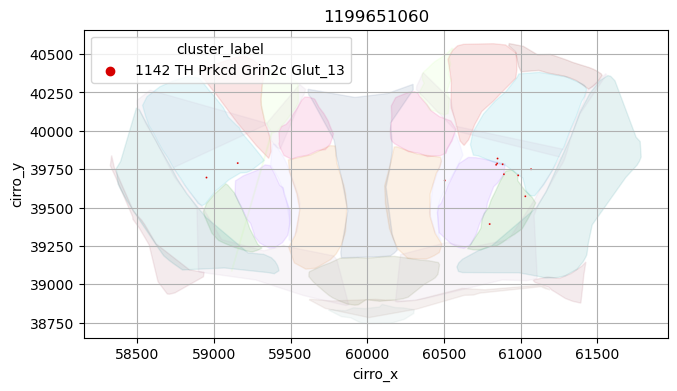

In [242]:
plot_nucleus_cluster_comparison_slices('VM', adata, nuclei_df, ccf_polygons)

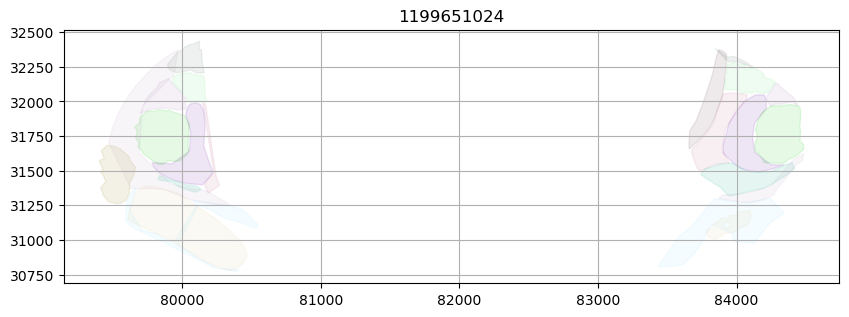

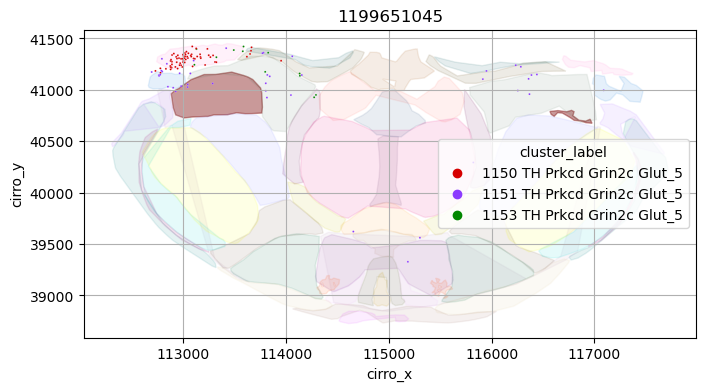

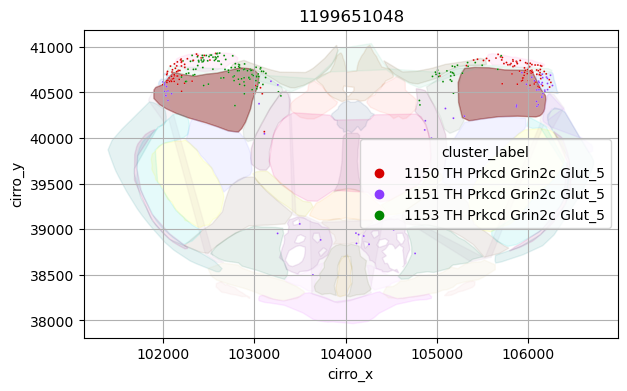

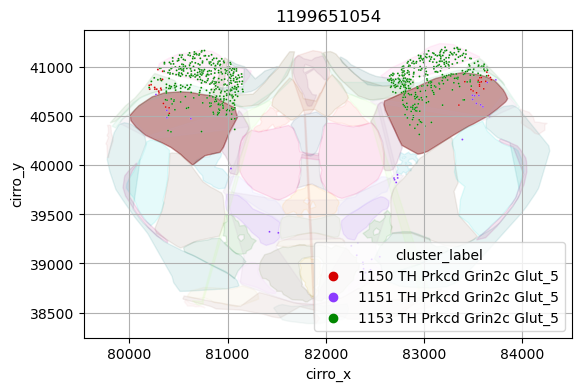

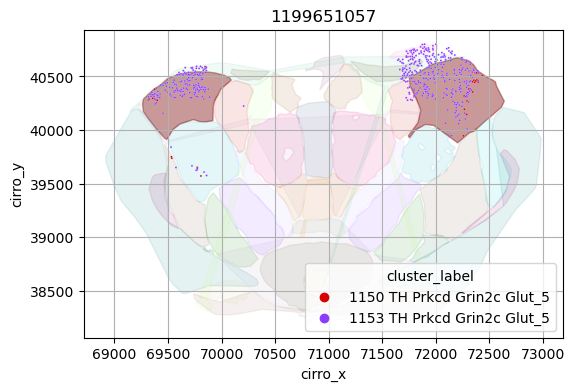

In [243]:
plot_nucleus_cluster_comparison_slices('LD', adata, nuclei_df, ccf_polygons)

## flat view plots

In [28]:
def plot_nucleus_cluster_comparison(name, adata, nuclei_df, ccf_polygons, subregions=None):
    plt.figure(figsize=(40,10))
    if subregions is not None:
        for x in subregions:
            for poly in ccf_polygons[x].values():
                splot.plot_polygon(poly, color='grey', add_points=False)
    else:
        for poly in ccf_polygons[name].values():
            splot.plot_polygon(poly, color='grey', add_points=False)
    clusters = nuclei_df.loc[name, "annotated clusters"].split(', ')
    df = adata.obs.loc[lambda df: df['cluster_label'].str[:4].isin(clusters)]
    df['cluster_label'].cat.remove_unused_categories(inplace=True)
    sns.scatterplot(df, x='cirro_x', y='cirro_y', hue='cluster_label', s=2)

<ipython-input-28-c2c25b0ddcf0>:16: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


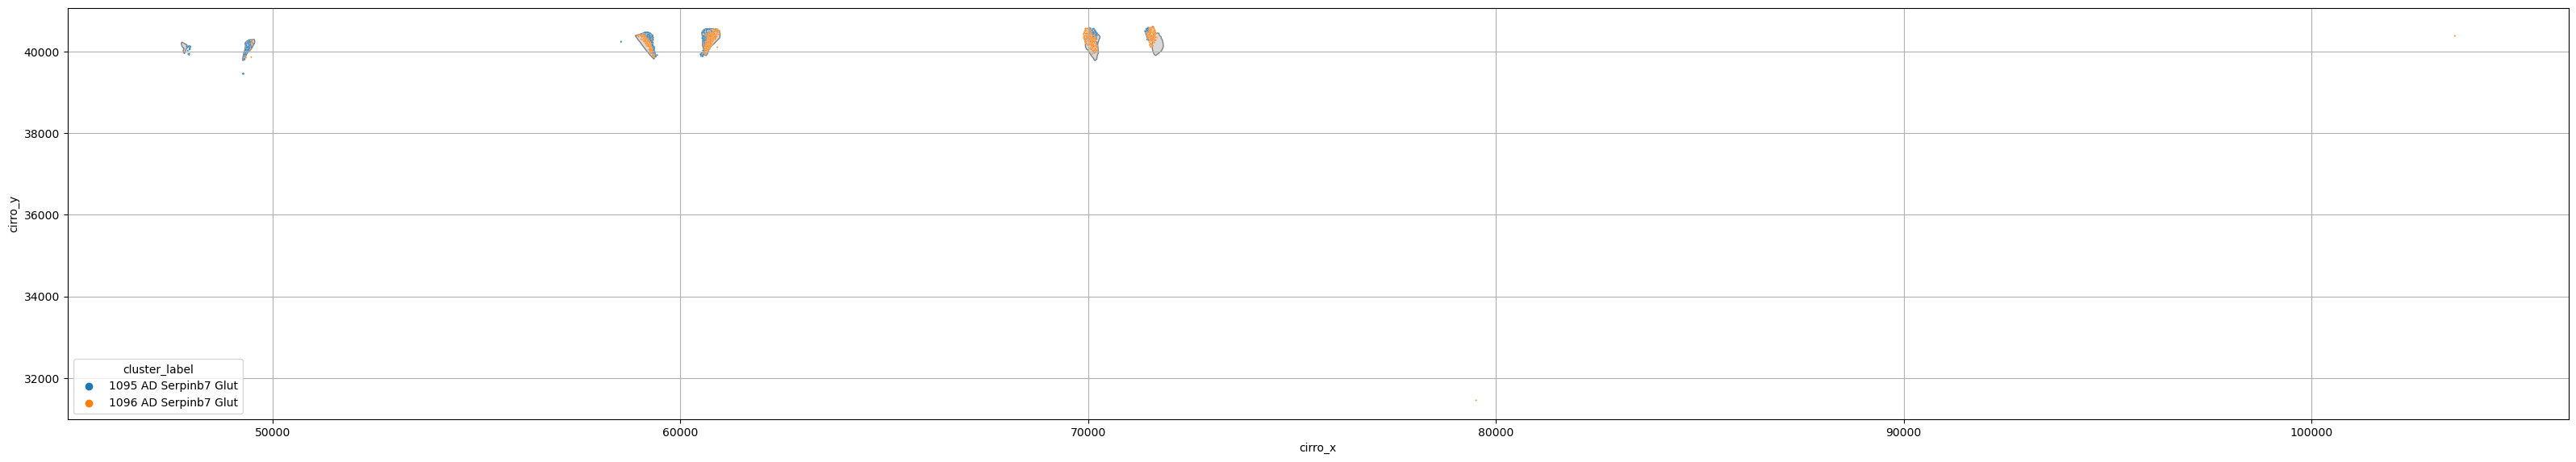

In [29]:
plot_nucleus_cluster_comparison('AD', adata, nuclei_df, ccf_polygons)

<ipython-input-28-c2c25b0ddcf0>:16: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


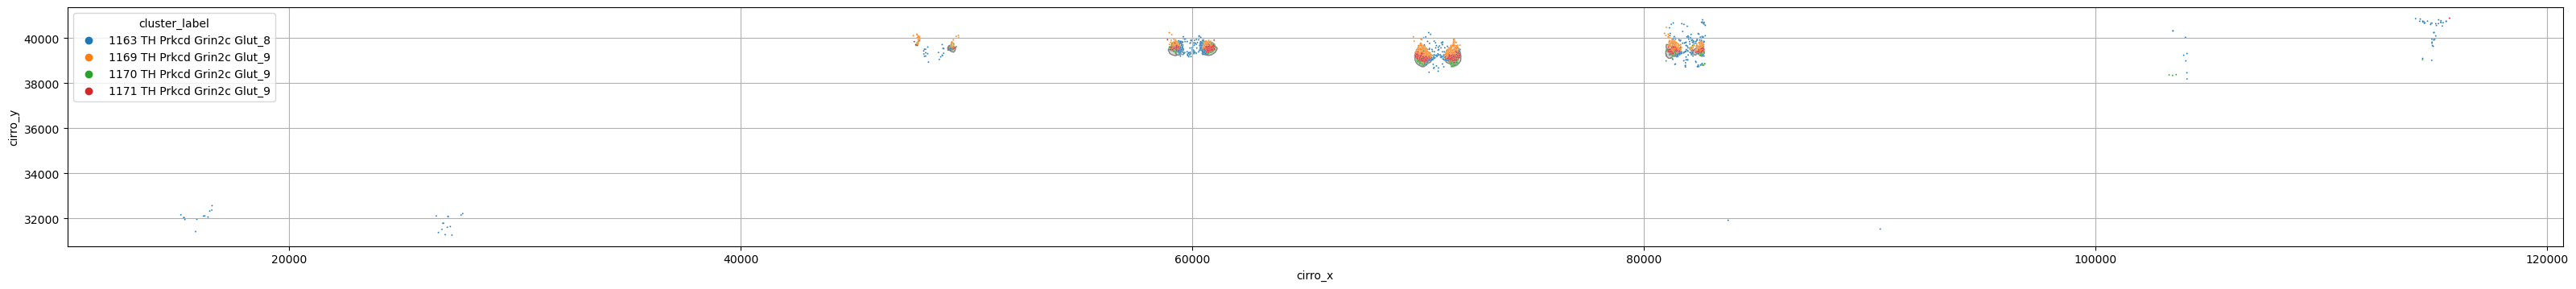

In [30]:
plot_nucleus_cluster_comparison('AM', adata, nuclei_df, ccf_polygons, subregions=['AMd','AMv'])

<ipython-input-15-ff7a9ff7786d>:11: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


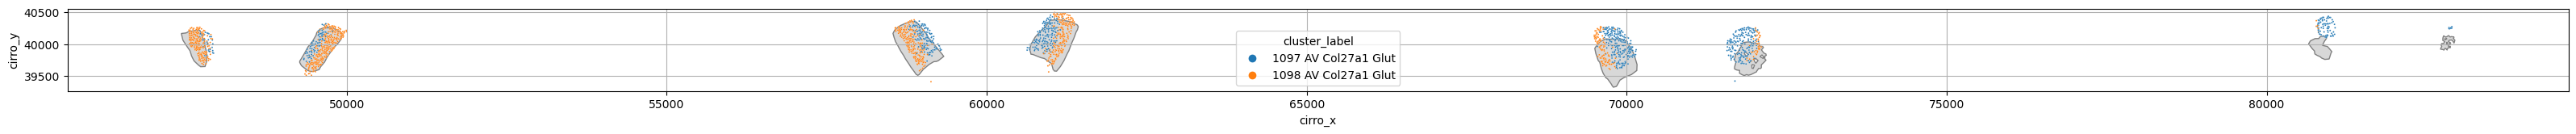

In [22]:
plot_nucleus_cluster_comparison('AV', adata, nuclei_df, ccf_polygons)

<ipython-input-28-c2c25b0ddcf0>:16: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


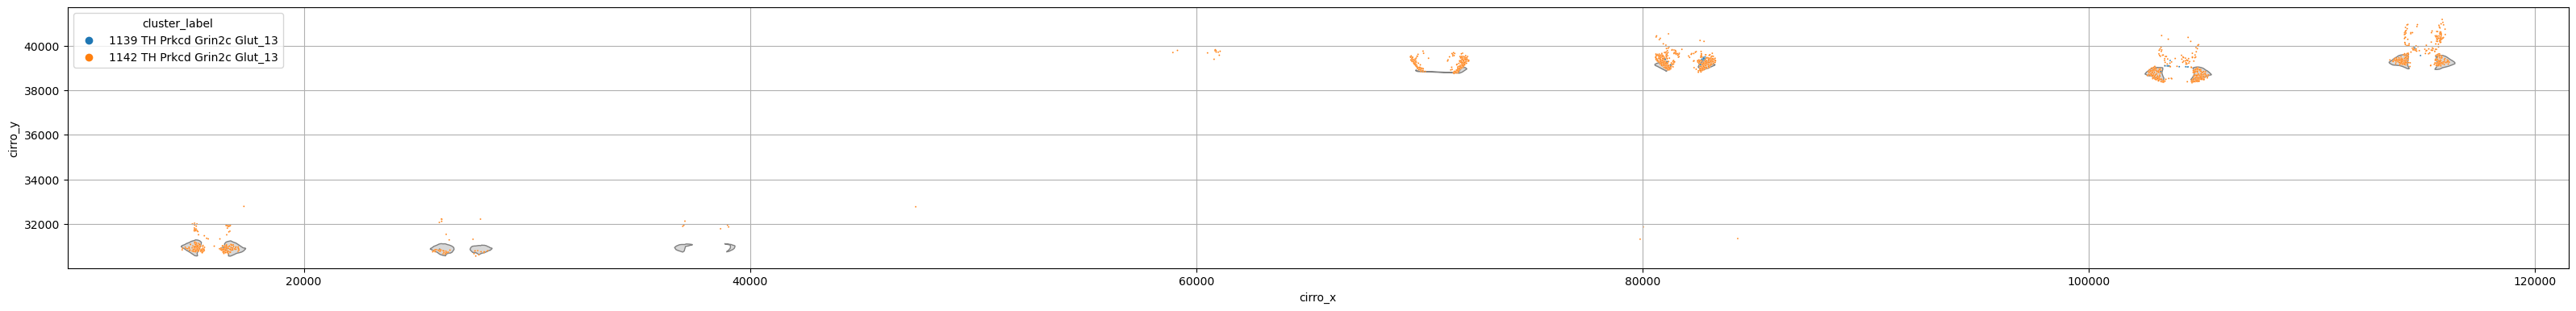

In [31]:
plot_nucleus_cluster_comparison('VM', adata, nuclei_df, ccf_polygons)

<ipython-input-28-c2c25b0ddcf0>:16: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['cluster_label'].cat.remove_unused_categories(inplace=True)


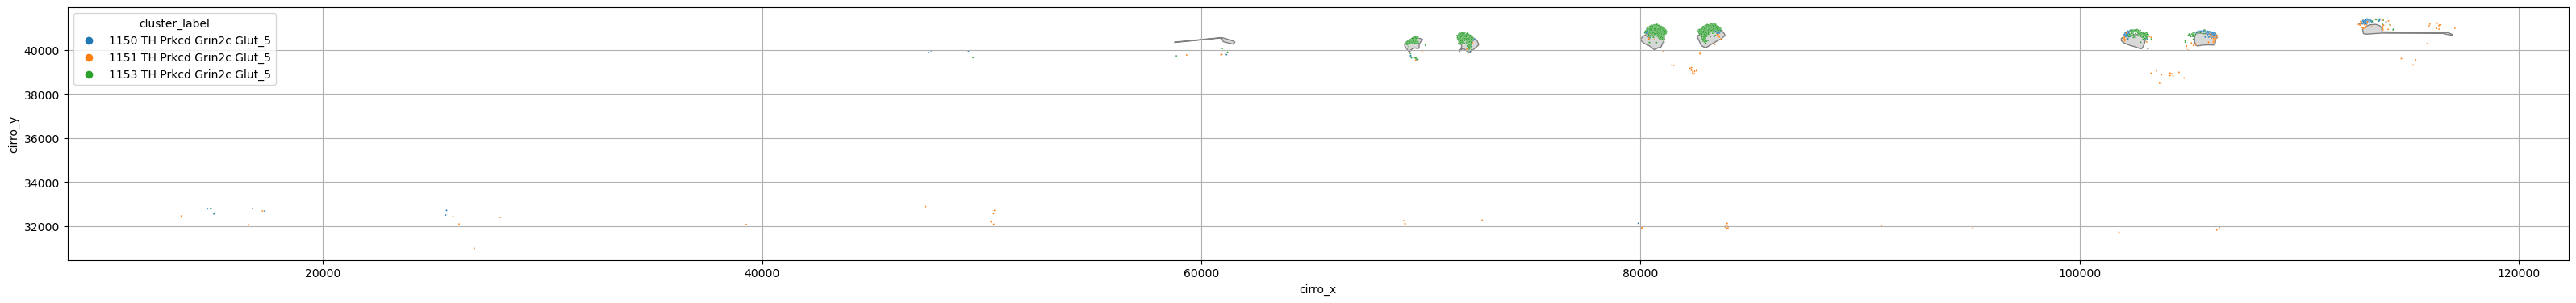

In [33]:
plot_nucleus_cluster_comparison('LD', adata, nuclei_df, ccf_polygons)